In [110]:
import time
import sys
from pathlib import Path

import torch

work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from datasets import Datasets, dl
from trans import Trans
from trainer import Trainer

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights

ds = Datasets(root=work_path / "assets/datasets/")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)]).limit_class(labels=[4, 82])
# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)]).limit_class(labels=[4, 30, 55, 72, 82])
# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)]).limit_class(labels=[4, 30, 55, 72, 95])
# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)]).limit_class(labels=[4, 1, 54, 9, 0])
# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)]).limit_class(labels=[6, 7, 14, 18, 24])
# train_ds = ds("cifar100_train", transform_l=[Trans.tsr, Trans.resize(224, 224)])
# train_ds = ds("mnist_train", transform_l=[Trans.tsr])

train_dl = dl(train_ds, batch_size=128)

# base_arc = resnet18(weights=ResNet18_Weights.DEFAULT)
base_arc = resnet50(weights=ResNet50_Weights.DEFAULT)
feat_extracter = torch.nn.Sequential(*list(base_arc.children())[:-1])

trainer = Trainer(network=feat_extracter)

# print(trainer.arc_check(dl=train_dl))


feat, labels = trainer.pred_1iter(train_dl)
feat = feat.view(len(feat), -1)
print(feat.shape)
print(labels.shape)
feat = feat.cpu()
labels = labels.cpu()


torch.Size([2500, 2048])
torch.Size([2500])


In [111]:
from tsnecuda import TSNE
from umap import UMAP

# X, y = train_ds.load_data(one_dim=True)
# tsne = TSNE(n_iter=1000, perplexity=30, num_neighbors=64, verbose=0)
# tsne = TSNE(n_iter=5000, perplexity=128, num_neighbors=128, verbose=0)
# print(X.shape)
# print(y.shape)

# tsne = TSNE(n_iter=3000, perplexity=500, num_neighbors=128, verbose=0)
# X, y = train_ds.load_data(one_dim=True)
# res = tsne.fit_transform(X)

umap = UMAP(n_neighbors=50, min_dist=0.1)
# umap = UMAP(n_neighbors=15, min_dist=0.1)
feat_2d = umap.fit_transform(feat)

2.9464774


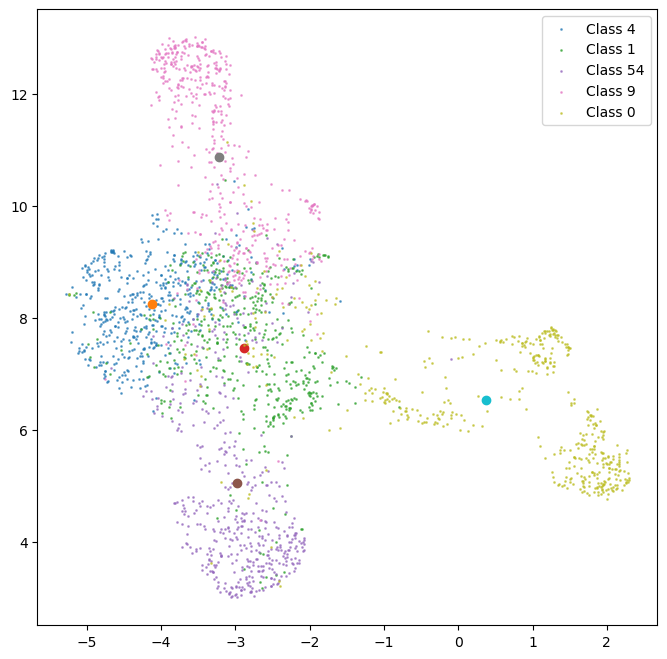

In [112]:
import numpy as np
import matplotlib.pyplot as plt
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1)

points = []

classes = train_ds.fetch_classes(listed=True)
for class_label in classes:
    class_mask = labels == class_label
    x = feat_2d[class_mask, 0]
    y = feat_2d[class_mask, 1]
    ax.scatter(x, y, label=f'Class {class_label}', alpha=0.6, s=1)

    class_center = np.array([x.mean(), y.mean()])
    points.append(class_center)
    ax.scatter(x=class_center[0], y=class_center[1])

ax.legend()
fig.show()

points = np.stack(points)
distance_matrix = np.sqrt(((points[:, np.newaxis, :] - points[np.newaxis, :, :]) ** 2).sum(axis=-1))

print(distance_matrix.mean())